# YOLO evaluation

In [1]:
import os
from ultralytics import YOLO
from PIL import Image
import numpy as np

In [2]:
image_folder="D:/Datasets/YOLO_1_Dataset/test/images"
label_folder="D:/Datasets/YOLO_1_Dataset/test/labels"

test_images= [f for f in os.listdir(image_folder) if f.endswith((".jpeg", ".JPEG"))]
test_labels= [f for f in os.listdir(label_folder) if f.endswith((".txt"))]
print(f"Gefundene testbilder: {len(test_images)}")
print(f"Gefundene testlabels: {len(test_labels)}")
print(os.path.splitext(test_images[0])[0])
image_bbox_pairs = [
                    (os.path.join(image_folder, img), os.path.join(label_folder,img.replace(".jpeg",".txt").replace(".JPEG",".txt")))
                    for img in  test_images
                    if img.replace(".jpeg",".txt").replace(".JPEG",".txt") in test_labels
]
print(f"Gefundene Paare: {len(image_bbox_pairs)}")


Gefundene testbilder: 5370
Gefundene testlabels: 5370
1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411
Gefundene Paare: 5370


In [3]:
def load_ground_truth(file_path, image_shape):
    h,w = image_shape[:2]
    boxes=[]

    with open(file_path, "r") as f:
        for line in f.readlines():
            class_id,x_center, y_center, width, height = map(float, line.strip().split())

            x_min = int((x_center - width/2)*w)
            y_min = int((y_center - width/2)*h)
            x_max = int((x_center + width/2)*w)
            y_max = int((y_center + width/2)*h)
        
            boxes.append([x_min,y_min,x_max,y_max])
    return boxes

In [5]:
model=YOLO("YOLO1/1/weights/best.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [6]:
predictions={}
ground_truths={}

for image_path, bbox_path in image_bbox_pairs:
    image = Image.open(image_path)

    image_np = np.array(image)

    gt_boxes = load_ground_truth(bbox_path, image_np.shape)
    ground_truths[os.path.basename(image_path)] = gt_boxes

    results = model(image_np)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    predictions[os.path.basename(image_path)]= {
        "boxes": boxes,
        "scores": scores,
        "classes": classes
    }


0: 512x512 (no detections), 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 12.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference,

In [8]:
def compute_iou(box1, box2):
    """
    Berechnet Intersection over Union (IoU) für zwei Bounding Boxes.
    Boxformat: [x_min, y_min, x_max, y_max]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Flächen von Intersection und Union berechnen
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def evaluate(predictions, ground_truths, iou_threshold=0.5, score_threshold=0.25):
    """
    Evaluierung der Vorhersagen im Vergleich zu den Ground Truths.
    predictions: Dictionary mit Vorhersagen
    ground_truths: Dictionary mit Ground Truths
    """
    tp, fp, fn, tn = 0, 0, 0, 0

    for image_id, gt_boxes in ground_truths.items():
        pred_boxes = predictions[image_id]['boxes']
        pred_scores = predictions[image_id]['scores']
        
        # Filter Vorhersagen basierend auf Score Threshold
        # pred_boxes = pred_boxes[pred_scores >= score_threshold]
        
        # Fall: Keine Ground Truth und keine Vorhersagen
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            tn += 1
            continue

        matched_gt = set()
        for pred_box in pred_boxes:
            # Berechne IoU mit allen Ground Truths
            ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious) if ious else 0  # maximaler IoU-Wert für diese Vorhersage
            
            if max_iou >= iou_threshold:
                # True Positive: Eine Ground Truth wurde erkannt
                matched_gt.add(ious.index(max_iou))
            for iou in ious:
                if iou >= iou_threshold:
                    # True Positive: Eine Ground Truth wurde erkann
                    tp += 1
                else:
                    # False Positive: Keine passende Ground Truth gefunden
                    fp += 1

        
        # False Negatives: Nicht erkannte Ground Truths
        fn += len(gt_boxes) - len(matched_gt)

    # Metriken berechnen
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "specificity": specificity,
        "f1_score": f1_score,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    }


results = evaluate(predictions, ground_truths)
print(results)


{'precision': 0.9247311827956989, 'recall': 0.921315108976727, 'accuracy': 0.9245556764599202, 'specificity': 0.9276807980049875, 'f1_score': 0.9230199851961509, 'tp': 2494, 'fp': 203, 'fn': 213, 'tn': 2604}


# CapsNet NOrmal Evaluation

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_normal_model import CapsuleNetwork, CapsuleLoss, display_images
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [2]:
BASE_DIR_TEST = "D:/YOLO_Caps/test"
seed = 41
batch_size = 16
classes = ["nodule", "non-nodule"]
image_size = 128
scenario = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)



In [4]:
checkpoint = torch.load("C:/Users/chris/Desktop/caps_normal.pt")
model_state_dict = checkpoint['model_state_dict']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capsule_net.load_state_dict(model_state_dict)
capsule_net.eval()
capsule_net.to(device)

print(capsule_net)

C:\Users\chris\AppData\Local\Temp\ipykernel_19716\2785319813.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("C:/Users/chris/Desktop/caps_normal.

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

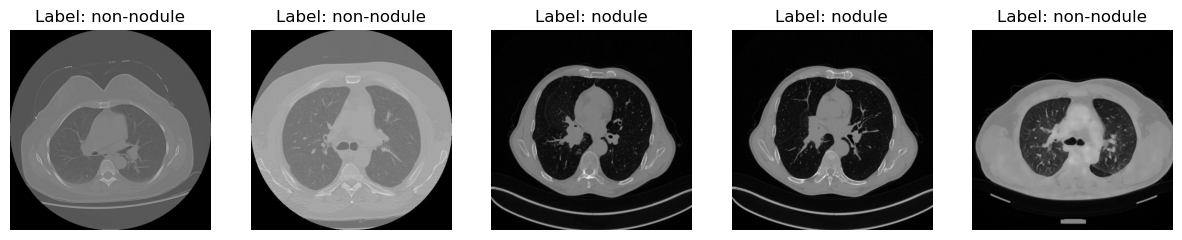

In [6]:
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "nodule"))), classes=classes, scenario=scenario)
test_dataset.visualize_images(num_images=5)

In [7]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512>, 0)

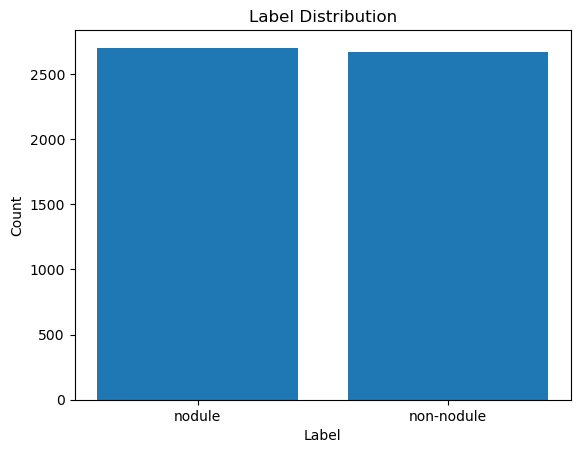

In [8]:
test_dataset.display_label_distribution()

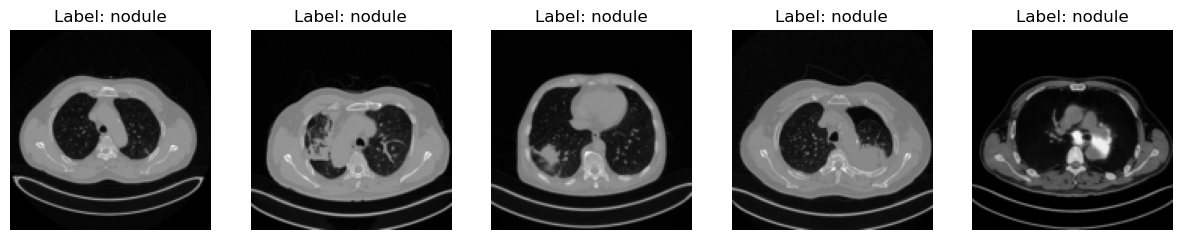

In [9]:
test_dataset = TransformDataset(test_dataset, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(test_loader, classes)

In [10]:
criterion = CapsuleLoss()
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

torch.Size([16, 256, 120, 120])


KeyboardInterrupt: 

In [44]:
caps_outputs

tensor([[[-9.2754e-04,  1.6812e-03,  3.1587e-03, -2.7112e-03, -5.7555e-04,  8.6583e-05, -1.0466e-03, -3.6498e-03, -2.2259e-03, -1.6177e-03,  1.0341e-03,  1.2929e-03,  1.0375e-03, -2.8802e-03,  2.8592e-03,  4.8662e-03],
         [ 2.1412e-01, -2.7104e-01, -2.8053e-01, -2.7244e-01,  1.7211e-01, -2.7896e-01,  2.4966e-01,  2.2414e-01,  2.3003e-01, -2.6870e-01, -2.7828e-01, -2.7845e-01, -2.7466e-01, -2.5893e-01,  2.0786e-01, -2.0472e-01]],

        [[-2.3284e-04,  1.3603e-04,  8.1906e-04, -1.0656e-03, -5.3537e-04, -2.7956e-04,  6.2072e-04, -1.1528e-03, -1.8470e-03, -1.5397e-03,  5.5134e-04, -7.7919e-04, -8.6234e-04, -7.4700e-04,  9.3564e-04,  1.0579e-03],
         [ 2.1362e-01, -2.7082e-01, -2.8116e-01, -2.7391e-01,  1.6970e-01, -2.7902e-01,  2.5212e-01,  2.2209e-01,  2.2831e-01, -2.6861e-01, -2.7843e-01, -2.7948e-01, -2.7397e-01, -2.5787e-01,  2.0899e-01, -2.0539e-01]],

        [[-4.4343e-04, -1.6065e-04,  8.0698e-05, -7.0125e-05,  1.2003e-03, -1.1705e-03,  1.2647e-03, -2.8055e-03,  6.164

# CapsNet Cropped Eval

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_cropped_model import CapsuleNetwork, CapsuleLoss, display_images
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [5]:
BASE_DIR_TEST = "D:/YOLO_Caps/YOLO_Caps/test"
seed = 41
batch_size = 16
classes = ["cropped_nodule", "cropped_non_nodule"]
image_size = 128
scenario = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)



In [7]:
checkpoint = torch.load("C:/Users/chris/Desktop/caps_crop.pt")
model_state_dict = checkpoint['model_state_dict']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capsule_net.load_state_dict(model_state_dict)
capsule_net.eval()
capsule_net.to(device)

print(capsule_net)

C:\Users\chris\AppData\Local\Temp\ipykernel_15504\2853144302.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("C:/Users/chris/Desktop/caps_crop.pt

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

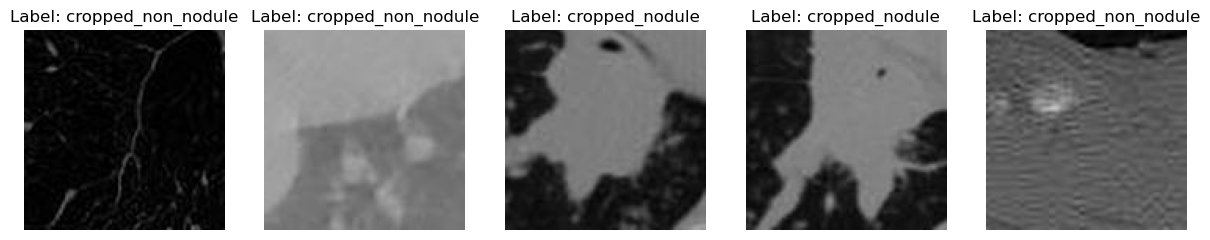

In [9]:
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "nodule"))), classes=classes, scenario=scenario)
test_dataset.visualize_images(num_images=5)

In [10]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=128x128>, 0)

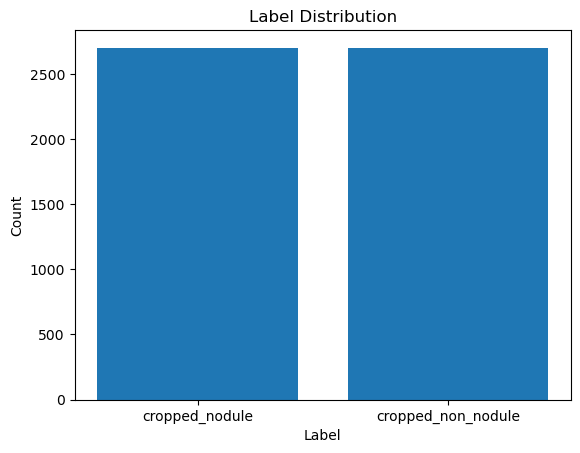

In [11]:
test_dataset.display_label_distribution()

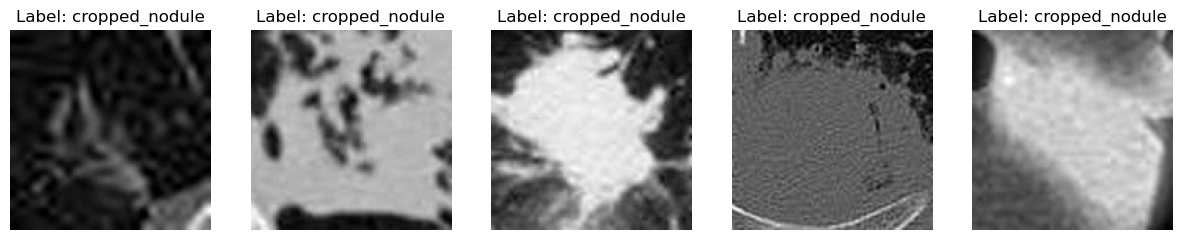

In [12]:
test_dataset = TransformDataset(test_dataset, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(test_loader, classes)

In [13]:
criterion = CapsuleLoss()
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True]))
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True]))
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True]))


KeyboardInterrupt: 

# Evaluate whole pipeline

In [15]:
image_folder="D:/YOLO_Dataset/test/images"
label_folder="D:/YOLO_Dataset/test/labels"

test_images= [f for f in os.listdir(image_folder) if f.endswith((".jpeg", ".JPEG"))]
test_labels= [f for f in os.listdir(label_folder) if f.endswith((".txt"))]
print(f"Gefundene testbilder: {len(test_images)}")
print(f"Gefundene testlabels: {len(test_labels)}")
print(os.path.splitext(test_images[0])[0])
image_bbox_pairs = [
                    (os.path.join(image_folder, img), os.path.join(label_folder,img.replace(".jpeg",".txt").replace(".JPEG",".txt")))
                    for img in  test_images
                    if img.replace(".jpeg",".txt").replace(".JPEG",".txt") in test_labels
]
print(f"Gefundene Paare: {len(image_bbox_pairs)}")


Gefundene testbilder: 5370
Gefundene testlabels: 5370
1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411
Gefundene Paare: 5370


In [16]:
def load_ground_truth(file_path, image_shape):
    h,w = image_shape[:2]
    boxes=[]

    with open(file_path, "r") as f:
        for line in f.readlines():
            class_id,x_center, y_center, width, height = map(float, line.strip().split())

            x_min = int((x_center - width/2)*w)
            y_min = int((y_center - width/2)*h)
            x_max = int((x_center + width/2)*w)
            y_max = int((y_center + width/2)*h)
        
            boxes.append([x_min,y_min,x_max,y_max])
    return boxes

In [17]:
model=YOLO("C:/Users/chris/Desktop/YOLO1_best.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [18]:
predictions={}
ground_truths={}

for image_path, bbox_path in image_bbox_pairs:
    image = Image.open(image_path)

    image_np = np.array(image)

    gt_boxes = load_ground_truth(bbox_path, image_np.shape)
    ground_truths[os.path.basename(image_path)] = gt_boxes

    results = model(image_np)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    predictions[os.path.basename(image_path)]= {
        "boxes": boxes,
        "scores": scores,
        "classes": classes
    }


0: 512x512 (no detections), 61.6ms
Speed: 5.0ms preprocess, 61.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 55.6ms
Speed: 1.0ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 51.9ms
Speed: 2.0ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 51.3ms
Speed: 2.0ms preprocess, 51.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 55.9ms
Speed: 0.0ms preprocess, 55.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms i

In [19]:
predictions

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=float32)},
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.jpeg': {'boxes': array([], shape=(0, 4), dtype=float32),
  'scores': array([], dtype=float32),
  'classes': array([], dtype=f

In [26]:
from PIL import Image, ImageDraw
import os


# Verzeichnisse
image_dir = "D:/YOLO_Dataset/test/images"  # Ordner mit den Originalbildern
output_dir = "D:/annotaed_img"  # Ordner, wo die Bilder mit Bounding Boxes gespeichert werden
os.makedirs(output_dir, exist_ok=True)

def draw_and_save_image_with_boxes(image_path, boxes, output_path):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    
    # Bounding Boxes zeichnen
    for box in boxes:
        x_min, y_min, x_max, y_max = box  # Annahme: [x_min, y_min, x_max, y_max]
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
    
    # Bild speichern
    image.save(output_path)
    print(f"Saved: {output_path}")

# Verarbeitung der ersten 100 Bilder
for idx, (image_name, info) in enumerate(predictions.items()):
    if idx >= 100:  # Nur die ersten 100 Bilder
        break
    
    image_path = os.path.join(image_dir, image_name)
    output_path = os.path.join(output_dir, image_name)
    
    # Nur speichern, wenn Bounding Boxes vorhanden sind
    if len(info['boxes']) > 0:
        draw_and_save_image_with_boxes(image_path, info['boxes'], output_path)


Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.100711050613761855156496841207.JPEG
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.101000900610617184701526787276.JPEG
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.101291121425729144303985968215.jpeg
Saved: D:/annotaed_img\1.3.6.1.4.1.14519.5.2.1.6655.2359.1013873921646

In [30]:
from PIL import Image
import os


# Verzeichnisse
image_dir = "D:/YOLO_Dataset/test/images"   # Ordner mit den Originalbildern
output_dir = "D:/annotaed_img/crop/TEST"  # Ordner, wo die gecroppten Bilder gespeichert werden
os.makedirs(output_dir, exist_ok=True)

   
def crop_and_save_image(image_path, boxes, output_name_base):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")
    
    # Alle Bounding Boxes croppen
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = map(int, box)  # Koordinaten runden und in int umwandeln
        print("original",x_min, y_min, x_max, y_max)
        width = x_max - x_min
        height = y_max - y_min
        max_side = max(width, height)
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        x_min = max(0, x_center - max_side / 2)
        y_min = max(0, y_center - max_side / 2)
        x_max = min(image.width, x_center + max_side / 2)
        y_max = min(image.height, y_center + max_side / 2)
        # # Konvertiere zu Ganzzahlen
        x_min, x_max = int(x_min), int(x_max)
        y_min, y_max = int(y_min), int(y_max)
        print("NEW",x_min, y_min, x_max, y_max)
        cropped_image = image.crop((x_min, y_min, x_max, y_max)) 
        cropped_image = cropped_image.resize((128, 128), Image.LANCZOS) # Cropping
        
        # Speicherpfad für das gecroppte Bild
        cropped_image_path = os.path.join(output_dir, f"{output_name_base}_crop_{i+1}.jpg")
        cropped_image.save(cropped_image_path)
        print(f"Saved cropped image: {cropped_image_path}")

for image_name, info in predictions.items():
    image_path = os.path.join(image_dir, image_name)
    output_name_base = os.path.splitext(image_name)[0]  # Basisname ohne Erweiterung
    
    # Nur croppen und speichern, wenn Bounding Boxes vorhanden sind
    if len(info['boxes']) > 0:
        crop_and_save_image(image_path, info['boxes'], output_name_base)



original 116 181 181 231
NEW 116 173 181 238
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528_crop_1.jpg
original 336 298 360 323
NEW 335 298 360 323
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196_crop_1.jpg
original 143 276 205 339
NEW 142 276 205 339
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239_crop_1.jpg
original 123 288 178 352
NEW 118 288 182 352
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981_crop_1.jpg
original 313 290 396 357
NEW 313 282 396 365
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845_crop_1.jpg
original 302 269 353 324
NEW 300 269 355 324
Saved cropped image: D:/annotaed_img/crop/TEST\1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393_cro

In [14]:
ground_truths

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.104507274032170320323347152411.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.104863864417205674007098486529.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108828997377593078753121028952.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109466173635014704200062503592.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109626634592628652877975591041.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109710522872080626618036223042.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116069400930896573799773712313.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.116221631153879627914984470663.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.118597469360280284504244918386.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.121898080754492407159861475149.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.138539218439961612704732946102.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.142868044429387263567069942743.jpeg': [],
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.1461657008134969218360078604

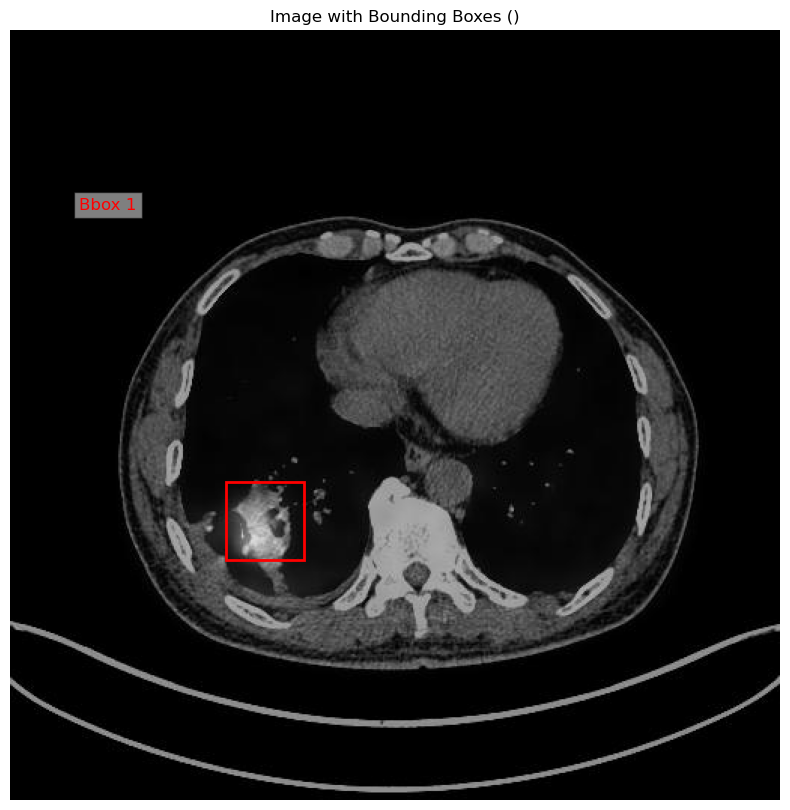

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Annahmen: 
# - `image` ist das Originalbild als NumPy-Array
# - `boxes` ist eine Liste von Bounding Boxes im Format [x_center, y_center, width, height]
# - `image_name` ist der Name des Bildes (falls benötigt)

def plot_image_with_bboxes(image, boxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    image=Image.open(image)
    ax.imshow(image)
    for i, box in enumerate(boxes):
        # Umrechnung der Bounding Box von [x_center, y_center, width, height] in [x_min, y_min, width, height]
        x_center, y_center, width, height = box
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        # Rechteck zeichnen
        rect = patches.Rectangle(
            (143, 300), 52, 52, linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        # Optional: Nummerierung der Bounding Boxes
        ax.text(
            x_min, y_min - 5, f"Bbox {i+1}",
            color="red", fontsize=12, bbox=dict(facecolor="white", alpha=0.5)
        )
    ax.set_title(f"Image with Bounding Boxes ()")
    plt.axis("off")
    plt.show()

# Beispielaufruf
plot_image_with_bboxes("D:/YOLO_Dataset/test/images/1.3.6.1.4.1.14519.5.2.1.6655.2359.153756550154583124737179851275.jpeg", [[143,
   300,
   195,
   352] ])


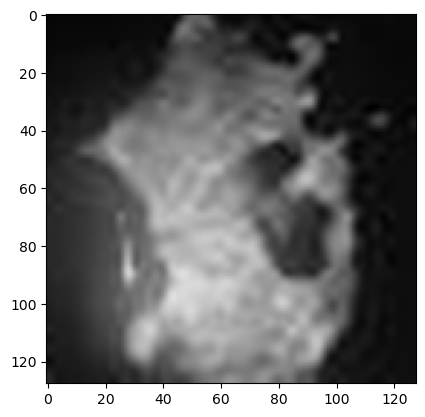

In [25]:
import os
import random
from PIL import Image
import shutil

test_folder="D:/YOLO_Dataset/test/images"
# Zähler für Non-Nodule-Bilder
non_nodule_counter = 0


def crop_and_resize(image, bbox, target_size=128):
    x_min, y_min, x_max, y_max = bbox

    # print(f"x_min{x_min}")
    # print(f"x_max{x_max}")
    # print(f"y_min{y_min}")
    # print(f"y_max{y_max}")
    
    # # Breite und Höhe berechnen
    # width = x_max - x_min
    # height = y_max - y_min

    # # Finde die maximale Seitenlänge
    # max_side = max(width, height)

    # # Zentriere die Box
    # x_center = (x_min + x_max) / 2
    # y_center = (y_min + y_max) / 2

    # x_min = max(0, x_center - max_side / 2)
    # y_min = max(0, y_center - max_side / 2)
    # x_max = min(image.width, x_center + max_side / 2)
    # y_max = min(image.height, y_center + max_side / 2)

    # # Konvertiere zu Ganzzahlen
    # x_min, x_max = int(x_min), int(x_max)
    # y_min, y_max = int(y_min), int(y_max)
    # # Crop und Resize
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    cropped_image = cropped_image.resize((target_size, target_size), Image.LANCZOS)
    plt.imshow(cropped_image)
    
    return cropped_image

def load_and_crop_per_image(predictions_dir):
    all_crops = []
    all_no_bbox=[]
    for image_name, data in predictions.items():
        
        # Lade das Bild
        image_path = os.path.join(test_folder, image_name)  # Nutze test_folder
        if not os.path.exists(image_path):
            print(f"Image {image_name} not found in {test_folder}")
            continue
        
        # Extrahiere die Bounding Boxen
        boxes = data['boxes']
        crop = []
        
        # Überprüfen, ob es Bounding Boxen gibt
        if len(boxes) > 0:
            # Croppen für jede Bounding Box
            for i, box in enumerate(boxes):
                # # Koordinaten für jede Box
                # x_center, y_center, width, height = box
                # Crop und Resize
                cropped_image = crop_and_resize(
                    Image.open("D:/YOLO_Dataset/test/images/1.3.6.1.4.1.14519.5.2.1.6655.2359.153756550154583124737179851275.jpeg",
                    bbox=[143,
   300,
   195,
   352],
                    target_size=image_size,
                )
                cropped_image = Image.fromarray(np.uint8(cropped_image))
                break
                all_crops.append((image_name, cropped_image))
            break
        else:
            # print(f"No bounding boxes for image: {image_name}")
            all_no_bbox.append(image_name)
    return all_crops, all_no_bbox

cropped_images_dict, no_bbox_array=load_and_crop_per_image(predictions)




In [16]:
len(cropped_images_dict)

2757

In [12]:
cropped_images_dict

[('1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870269820953143768196.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100072635488116034651642445239.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100156561188861970258198914981.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100423729079097357558203729845.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100436650956340012584392599393.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100546121805341655431102542094.jpeg',
  <PIL.Image.Image image mode=RGB size=128x128>),
 ('1.3.6.1.4.1.14519.5.2.1.6655.2359.100711050613761855156496841207.JPEG',
  <PIL.Image.Image image mode=RGB size=128x128>),


In [14]:
torch.save(cropped_images_dict, 'cropped_images_dict.pt')


In [18]:
len(no_bbox_array)

2613

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_cropped_model import CapsuleNetwork, CapsuleLoss, display_images
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset, TransformDatasetFinal


In [2]:
cropped_images_dict=torch.load("cropped_images_dict.pt")

C:\Users\chris\AppData\Local\Temp\ipykernel_63264\386762044.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cropped_images_dict=torch.load("cropped_images_dict.pt")


In [2]:
BASE_DIR_TEST = "D:/annotaed_img/crop"
seed = 41
batch_size = 16
classes = ["TEST", "KEIN_TEST"]
image_size = 128
scenario = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

TypeError: list indices must be integers or slices, not str

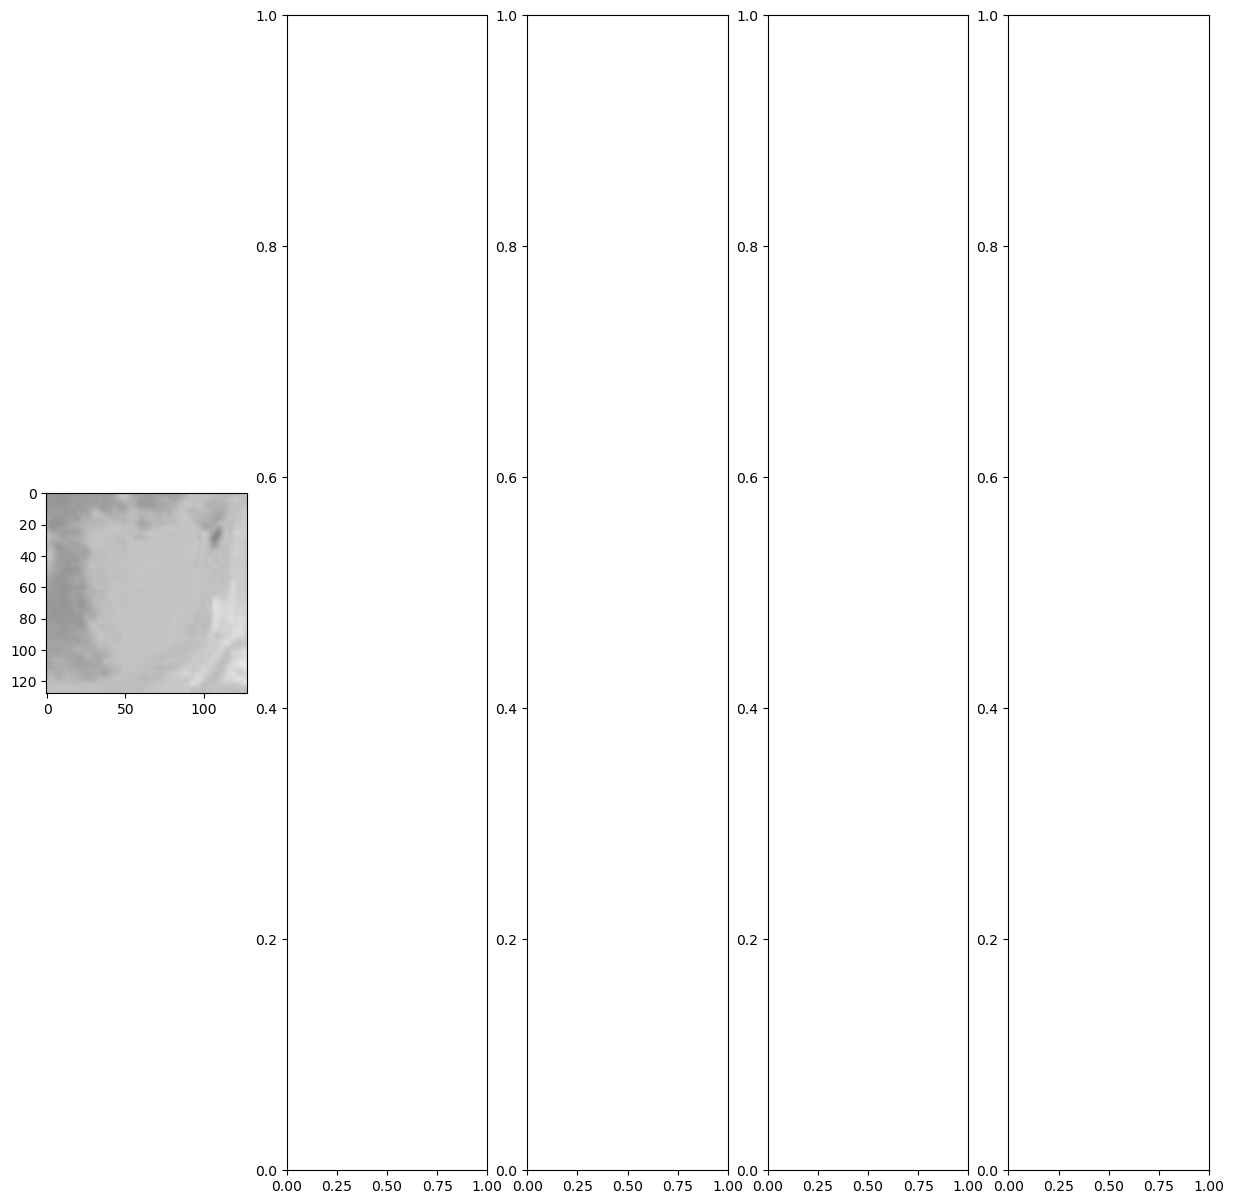

In [3]:
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "TEST"))), classes=classes, scenario=scenario)
test_dataset.visualize_images(num_images=5)

In [5]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=128x128>,
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.479296688495663090411829052528_crop_1.jpg')

C:\Users\chris\AppData\Local\Temp\ipykernel_47216\1241671107.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("C:/Users/chris/Desktop/caps_crop.pt

AttributeError: 'str' object has no attribute 'item'

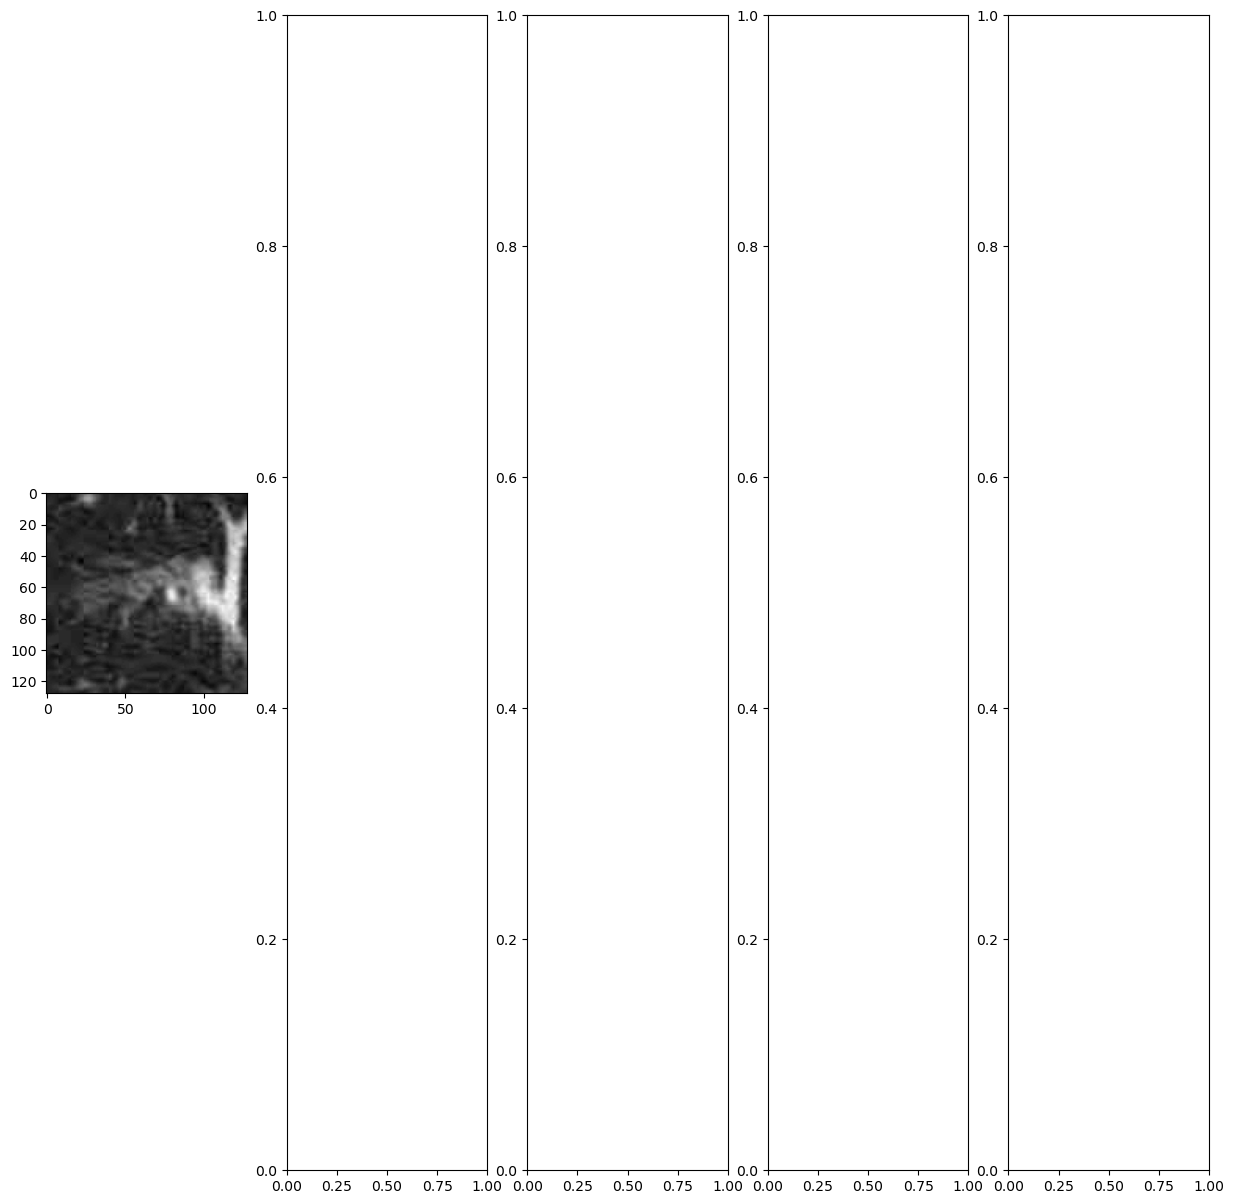

In [4]:

TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
checkpoint = torch.load("C:/Users/chris/Desktop/caps_crop.pt")
model_state_dict = checkpoint['model_state_dict']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capsule_net.load_state_dict(model_state_dict)
capsule_net.to(device)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
test_dataset = TransformDataset(test_dataset, transform=transform)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(test_loader, classes)

# # Transformiere das cropped_image
# test_dataset = TransformDatasetFinal(cropped_images_dict, transform)




# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:


preds,paths = capsule_net.run_model(test_loader)



Batch number:  0
Batch number:  1
Batch number:  2
Batch number:  3
Batch number:  4
Batch number:  5
Batch number:  6
Batch number:  7
Batch number:  8
Batch number:  9
Batch number:  10
Batch number:  11
Batch number:  12
Batch number:  13
Batch number:  14
Batch number:  15
Batch number:  16
Batch number:  17
Batch number:  18
Batch number:  19
Batch number:  20
Batch number:  21
Batch number:  22
Batch number:  23
Batch number:  24
Batch number:  25
Batch number:  26
Batch number:  27
Batch number:  28
Batch number:  29
Batch number:  30
Batch number:  31
Batch number:  32
Batch number:  33
Batch number:  34
Batch number:  35
Batch number:  36
Batch number:  37
Batch number:  38
Batch number:  39
Batch number:  40
Batch number:  41
Batch number:  42
Batch number:  43
Batch number:  44
Batch number:  45
Batch number:  46
Batch number:  47
Batch number:  48
Batch number:  49
Batch number:  50
Batch number:  51
Batch number:  52
Batch number:  53
Batch number:  54
Batch number:  55
Ba

In [9]:
torch.save(preds,"preds_caps.pt")

In [10]:
torch.save(paths,"paths_caps.pt")

In [5]:
classified_nodule = []  # Liste für nodule Bilder
classified_non_nodule = []  # Liste für non-nodule Bilder

for image_name, crops in cropped_images_dict.items():
    is_nodule = False  # Flag, das anzeigt, ob eines der Crops ein Nodule ist

    for crop in crops:
        print(crop)
        # Klassifikation des einzelnen Crops
        if classify_cropped_image(crop) == 0:  # Nodule-Klassifikation (0 für Nodule)
            is_nodule = True
            break  # Wenn eines der Crops als Nodule klassifiziert wurde, brechen wir die Schleife ab

    # Füge die entsprechenden Listen hinzu
    if is_nodule:
        classified_nodule.append(image_name)  # Das Originalbild zur Nodule-Liste hinzufügen
    else:
        print(classify_cropped_image(crop))
        classified_non_nodule.append(image_name)  # Das Originalbild zur Non-Nodule-Liste hinzufügen



<PIL.Image.Image image mode=RGB size=128x128 at 0x2B049E71640>
test_dataset tensor([[[-0.8667, -0.8667, -0.8588,  ..., -0.9765, -0.9686, -0.9686],
         [-0.8510, -0.8510, -0.8431,  ..., -0.9686, -0.9686, -0.9686],
         [-0.8275, -0.8275, -0.8275,  ..., -0.9608, -0.9608, -0.9608],
         ...,
         [-0.0824, -0.0824, -0.0902,  ..., -0.8275, -0.8431, -0.8431],
         [-0.0902, -0.0902, -0.0980,  ..., -0.8039, -0.8196, -0.8275],
         [-0.0902, -0.0902, -0.0980,  ..., -0.7882, -0.8039, -0.8118]]])
test_dataset_shape torch.Size([1, 128, 128])
dataloader<torch.utils.data.dataloader.DataLoader object at 0x000002B049907260>
torch.Size([1, 128, 128])
shape x torch.Size([256, 120, 120])
new x shape[0] 256
new x shape torch.Size([1, 256, 120, 120])
outchannels 32


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image
import shutil
import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_normal_model import CapsuleNetwork

from caps_utils import CAPS_Productive_Dataset, display_data_loader_batch, TransformDataset
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.57  Python-3.12.3 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Setup complete  (12 CPUs, 31.9 GB RAM, 340.1/397.5 GB disk)


In [2]:
BASE_DIR_TEST = "D:/Datasets"
seed = 41
batch_size = 16
classes = ["yolo1_predicted_non_nodule", "Non_Nodules"]
image_size = 128
scenario = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
test_dataset = CAPS_Productive_Dataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "yolo1_predicted_non_nodule"))), classes=classes, scenario=scenario)


In [4]:
len(test_dataset)

2637